# Program to prepare data & train NNs
---

In [1]:
import pandas as pd
import numpy as np
import sklearn

In [2]:
F_ID = "44184"

df = pd.read_csv(f"data/intervals/df/{F_ID}_data.csv")
# df.describe()

In [3]:
def normalise_series(data):
    max_point, min_point, median_value = data.max(), data.min(), np.median(data)
    return (data - median_value) / abs(max_point - min_point)

In [4]:
POINTS_DIM = 1024

In [5]:
data = []

l_edge = 0
step = 100

while l_edge + POINTS_DIM < df.shape[0]:
    df_slice = df.iloc[l_edge:l_edge + POINTS_DIM]
    data.append([normalise_series(df_slice.ch1.to_numpy()), 
                 df_slice.ch1_marked.to_numpy()])
    l_edge += step

if l_edge + POINTS_DIM - step != df.shape[0] - 1:
    # print(df.shape[0] - l_edge)
    df_slice = df.iloc[df.shape[0] - POINTS_DIM:]
    data.append([normalise_series(df_slice.ch1.to_numpy()),
                df_slice.ch1_marked.to_numpy()])

data_array = np.array(data)

data_array.shape

(651, 2, 1024)

In [6]:
# !pip install tensorflow

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(data_array[:, 0], data_array[:, 1], test_size=0.1, random_state=42)
X_train, y_train = data_array[:, 0], data_array[:, 1]
# print(X_train[:10], y_train[:10])

In [9]:
X_train.shape

(651, 1024)

In [10]:
def unet_model():

    #Входной слой
    inputs = tf.keras.layers.Input(shape=(POINTS_DIM, 1,))
    conv_1 = tf.keras.layers.Conv1D(64, 4, 
                                    activation=tf.keras.layers.LeakyReLU(),
                                    strides=2, padding='same', 
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(inputs)
    #Сворачиваем
    conv_1_1 = tf.keras.layers.Conv1D(128, 4, 
                                      activation=tf.keras.layers.LeakyReLU(), 
                                      strides=2,
                                      padding='same', 
                                      kernel_initializer='glorot_normal',
                                      use_bias=False)(conv_1)
    batch_norm_1 = tf.keras.layers.BatchNormalization()(conv_1_1)

    #2
    conv_2 = tf.keras.layers.Conv1D(256, 4, 
                                    activation=tf.keras.layers.LeakyReLU(), 
                                    strides=2,
                                    padding='same', 
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(batch_norm_1)
    batch_norm_2 = tf.keras.layers.BatchNormalization()(conv_2)

    #3
    conv_3 = tf.keras.layers.Conv1D(512, 4, 
                                    activation=tf.keras.layers.LeakyReLU(), 
                                    strides=2,
                                    padding='same', 
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(batch_norm_2)
    batch_norm_3 = tf.keras.layers.BatchNormalization()(conv_3)

    #4
    conv_4 = tf.keras.layers.Conv1D(512, 4, 
                                    activation=tf.keras.layers.LeakyReLU(), 
                                    strides=2,
                                    padding='same', 
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(batch_norm_3)
    batch_norm_4 = tf.keras.layers.BatchNormalization()(conv_4)

    #5
    conv_5 = tf.keras.layers.Conv1D(512, 4, 
                                    activation=tf.keras.layers.LeakyReLU(), 
                                    strides=2,
                                    padding='same', 
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(batch_norm_4)
    batch_norm_5 = tf.keras.layers.BatchNormalization()(conv_5)

    #6
    conv_6 = tf.keras.layers.Conv1D(512, 4, 
                                    activation=tf.keras.layers.LeakyReLU(), 
                                    strides=2,
                                    padding='same', 
                                    kernel_initializer='glorot_normal',
                                    use_bias=False)(batch_norm_5)

    #Разворачиваем
    #1
    up_1 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv1DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(conv_6), conv_5])
    batch_up_1 = tf.keras.layers.BatchNormalization()(up_1)

    #Добавим Dropout от переобучения
    batch_up_1 = tf.keras.layers.Dropout(0.25)(batch_up_1)

    #2
    up_2 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv1DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_1), conv_4])
    batch_up_2 = tf.keras.layers.BatchNormalization()(up_2)
    batch_up_2 = tf.keras.layers.Dropout(0.25)(batch_up_2)




    #3
    up_3 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv1DTranspose(512, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_2), conv_3])
    batch_up_3 = tf.keras.layers.BatchNormalization()(up_3)
    batch_up_3 = tf.keras.layers.Dropout(0.25)(batch_up_3)




    #4
    up_4 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv1DTranspose(256, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_3), conv_2])
    batch_up_4 = tf.keras.layers.BatchNormalization()(up_4)


    #5
    up_5 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv1DTranspose(128, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_4), conv_1_1])
    batch_up_5 = tf.keras.layers.BatchNormalization()(up_5)


    #6
    up_6 = tf.keras.layers.Concatenate()([tf.keras.layers.Conv1DTranspose(64, 4, activation='relu', strides=2,
                                                                          padding='same',
                                                                          kernel_initializer='glorot_normal',
                                                                          use_bias=False)(batch_up_5), conv_1])
    batch_up_6 = tf.keras.layers.BatchNormalization()(up_6)


    #Выходной слой
    max_pool = tf.keras.layers.MaxPooling1D(pool_size=2)(batch_up_6)
    flat = tf.keras.layers.Flatten()(max_pool)
    flat = tf.keras.layers.Dropout(0.1)(flat, training=True)
    outputs = tf.keras.layers.Dense(POINTS_DIM, activation="sigmoid")(flat)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
model = unet_model()

In [12]:
def focal_loss(y_true, y_pred, alpha=0.1, gamma=2.0):
    bce = K.binary_crossentropy(y_true, y_pred)

    y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
    p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))

    alpha_factor = y_true * alpha + ((1 - alpha) * (1 - y_true))
    modulating_factor = K.pow((1 - p_t), gamma)

    # compute the final loss and return
    return K.mean(alpha_factor * modulating_factor * bce, axis=-1)

def dice_bce_loss(y_pred, y_true):
    def dice_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.math.sigmoid(y_pred)
        numerator = 2 * tf.reduce_sum(y_true * y_pred)
        denominator = tf.reduce_sum(y_true + y_pred)
        
        return 1 - numerator / denominator
    total_loss = 0.25 * dice_loss(y_pred, y_true) + tf.keras.losses.binary_crossentropy(y_pred, y_true)
    return total_loss

In [13]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

---
## Learning side
---

In [14]:
ckpt_v = 1
checkpoint_filepath = f'models/ckpt/checkpoint_{ckpt_v}.weights.h5'
model.compile(optimizer='adam', loss=dice_bce_loss,
                  metrics=['acc', precision, recall])
model.load_weights(checkpoint_filepath)

D:\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 76 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [15]:
NUM_EPOCHS = 100
callbacks_metric = 'val_precision'
ckpt_v = 2
checkpoint_filepath = f'models/ckpt/checkpoint_{ckpt_v}.weights.h5'
callbacks_list = [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                     save_weights_only=True,
                                                     monitor=callbacks_metric,
                                                     mode='max',
                                                     save_best_only=True)]

In [ ]:

model.compile(optimizer='adam', loss=dice_bce_loss,
                  metrics=['acc', precision, recall])
model.fit(X_train, y_train, epochs=NUM_EPOCHS,callbacks=callbacks_list, validation_split=0.2, batch_size=64)
model.load_weights(checkpoint_filepath)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - acc: 0.0205 - loss: 0.8398 - precision: 0.6569 - recall: 0.7086 - val_acc: 0.0000e+00 - val_loss: 1.0967 - val_precision: 0.2914 - val_recall: 0.1850
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - acc: 0.0114 - loss: 0.3717 - precision: 0.8395 - recall: 0.8166 - val_acc: 0.0076 - val_loss: 0.6870 - val_precision: 0.4016 - val_recall: 0.3202
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - acc: 0.0053 - loss: 0.2911 - precision: 0.8969 - recall: 0.8531 - val_acc: 0.0000e+00 - val_loss: 0.6073 - val_precision: 0.4328 - val_recall: 0.7262
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - acc: 0.0312 - loss: 0.2289 - precision: 0.9244 - recall: 0.9628 - val_acc: 0.0000e+00 - val_loss: 0.5679 - val_precision: 0.5596 - val_recall: 0.3414
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - acc: 0.0184 - loss: 0.2202 - precision: 0.9820 - recall: 0.9191 - val_acc: 0.0076 - val_loss: 0.6389 - val_precision: 0.4392 - val_recall: 0.8403
Epo

---
## Marking side
---

In [14]:
ckpt_v = 3
checkpoint_filepath = f'models/ckpt/checkpoint_{ckpt_v}.weights.h5'

model.load_weights(checkpoint_filepath)

In [66]:
import os.path
from source.Files_operating import read_dataFile

interval_path = "data/intervals/"
signal_path = "data/d-alpha/"

check_filename = "sht44184"
check_F_ID = check_filename[-5:]

if os.path.isfile(interval_path + f"df/{check_F_ID}_data.csv"):
    new_df = pd.read_csv(interval_path + f"df/{check_F_ID}_data.csv", sep=",")
else:
    new_df = pd.read_csv(interval_path + f"{check_filename}.txt", sep=",")  # read_dataFile(interval_path + check_filename + ".txt", check_F_ID)  # "_exportGlobus2.dat"
    new_df["ch1_marked"] = pd.Series([0] * new_df.shape[0])
    new_df["ch1_ai_marked"] = pd.Series([0] * new_df.shape[0])

new_df.head()

,t,ch1,ch1_marked,ch1_ai_marked
0,164.470,0.51634,1,0.332097
1,164.471,0.50612,1,0.964986
2,164.472,0.50101,1,0.975182
3,164.473,0.48823,1,0.969223
4,164.474,0.48567,1,0.985926


In [53]:
new_df = new_df.rename(columns={"D-alpha_h50": "ch1"})
new_df.head()

,t,ch1,ch1_marked,ch1_ai_marked
0,0.000000,-0.028118,0,0
1,0.000001,0.025562,0,0
2,0.000002,0.030674,0,0
3,0.000003,0.033230,0,0
4,0.000004,0.030674,0,0


In [54]:
new_df.shape

(393216, 4)

In [55]:
l_edge = 0
POINTS_DIM = 1024
step = 512

# slice_data = X_train
# print(slice_data.shape)

# predictions = model.predict(np.array([normalise_series(new_df.loc[l_edge:l_edge + POINTS_DIM - 1, "ch1"])]))
# print(predictions.shape)

while l_edge + POINTS_DIM < new_df.shape[0]:
    predictions = model.predict(np.array([normalise_series(new_df.loc[l_edge:l_edge + POINTS_DIM - 1, "ch1"])]), verbose=0)
    for i in range(0, POINTS_DIM):
        new_df.loc[l_edge + i, "ch1_ai_marked"] = predictions[0][i]  # min(new_df.loc[l_edge + i, "ch1_marked"] + predictions[0][i], 1)
    l_edge += step

if l_edge + POINTS_DIM - step != new_df.shape[0] - 1:
    predictions = model.predict(np.array([new_df.loc[new_df.shape[0] - POINTS_DIM:new_df.shape[0], "ch1"]]))
    for i in range(0, POINTS_DIM):
        new_df.loc[new_df.shape[0] - POINTS_DIM + i, "ch1_ai_marked"] = predictions[0][i]  # min(new_df.loc[new_df.shape[0] - POINTS_DIM + i, "ch1_marked"] + predictions[0][i], 1)

new_df.head()
new_df.to_csv(signal_path + f"df/{check_F_ID}_data.csv", index=False)

C:\Users\fvdel\AppData\Local\Temp\ipykernel_2176\483425140.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5.3172699939927834e-14' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_df.loc[l_edge + i, "ch1_ai_marked"] = predictions[0][i]  # min(new_df.loc[l_edge + i, "ch1_marked"] + predictions[0][i], 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Input start index [0:65970]:  0


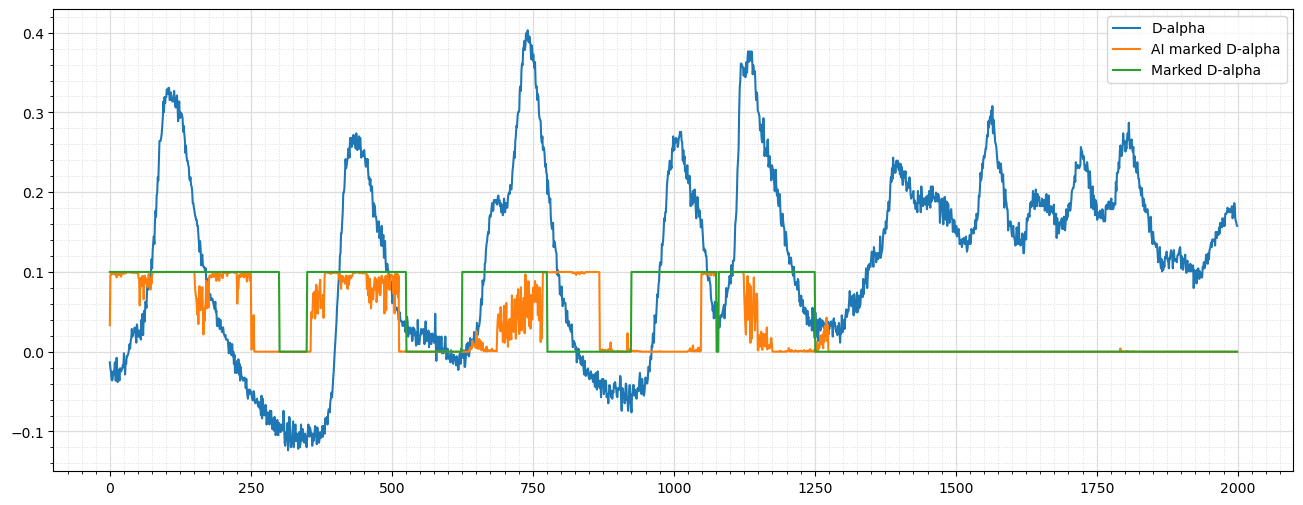

Input index pairs of ELM fragments:
 


<Figure size 640x480 with 0 Axes>

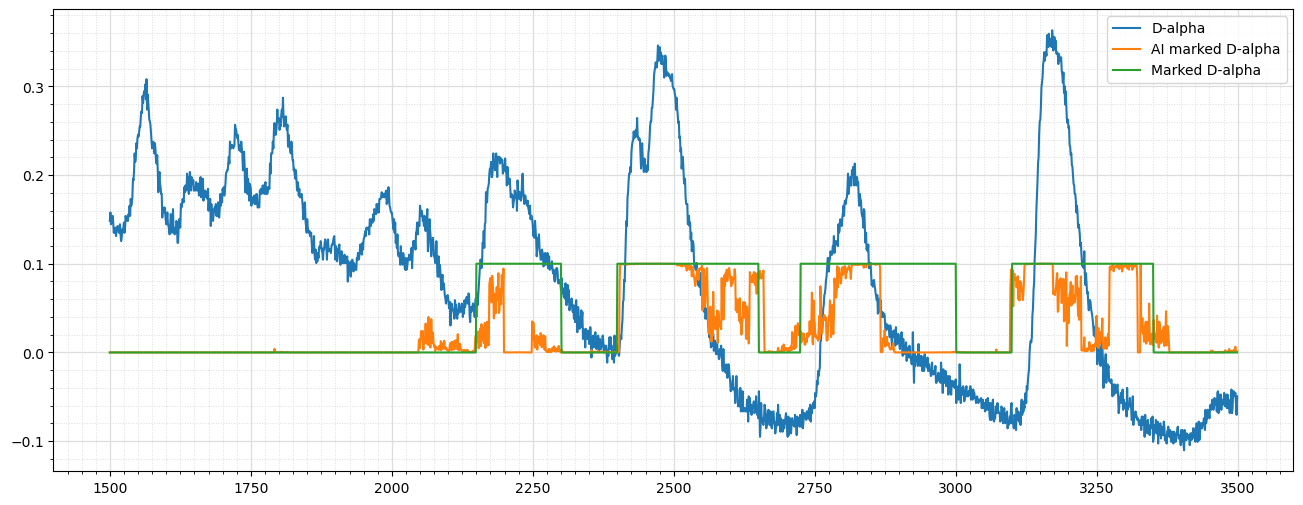

Input index pairs of ELM fragments:
 


<Figure size 640x480 with 0 Axes>

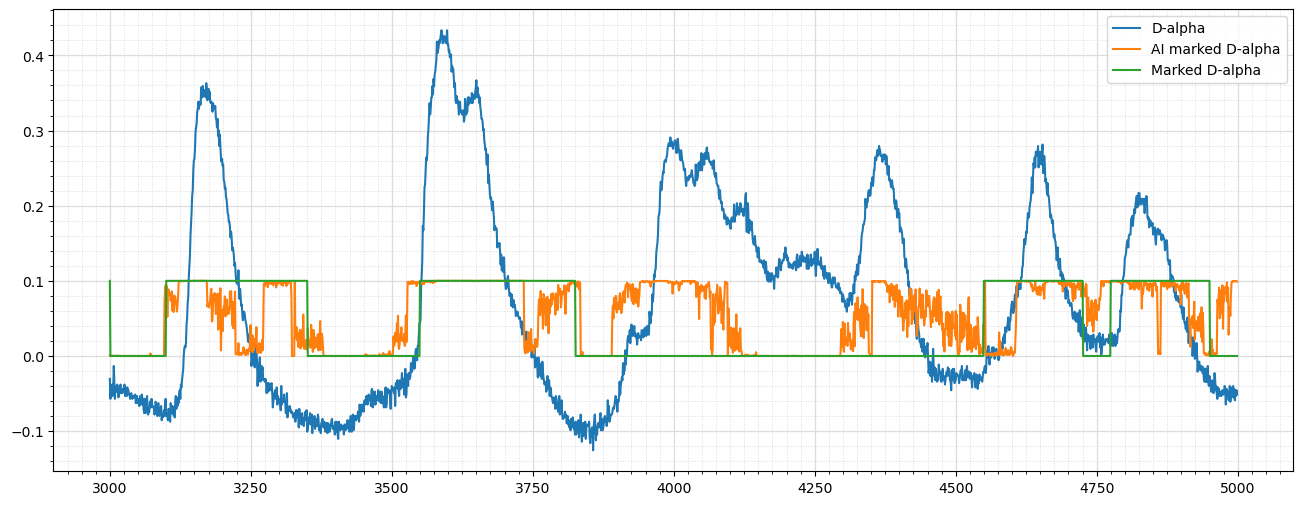

Input index pairs of ELM fragments:
 


<Figure size 640x480 with 0 Axes>

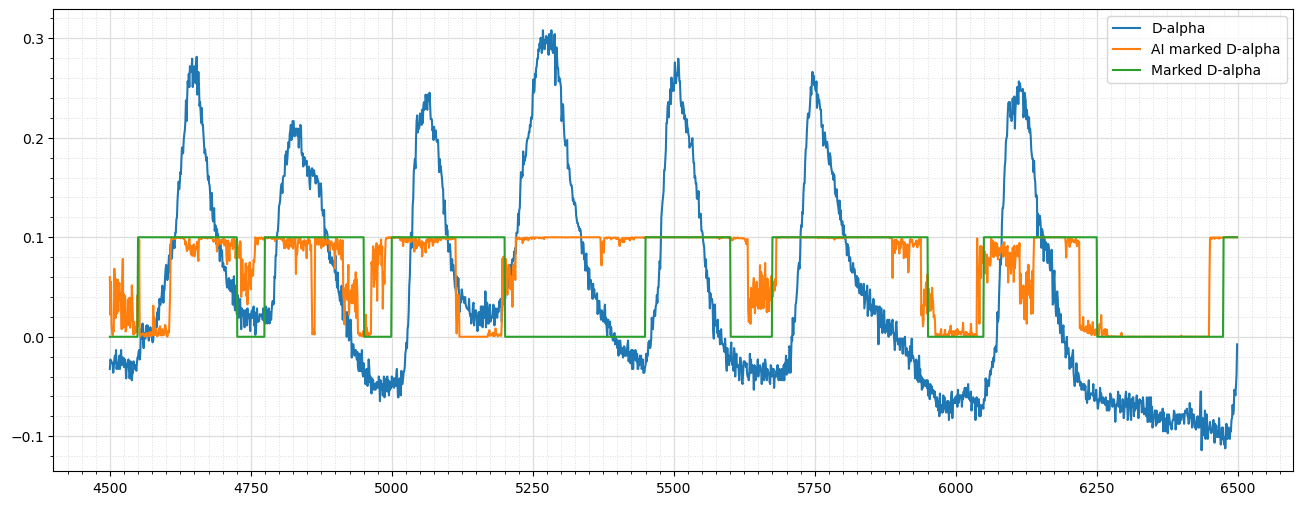

Input index pairs of ELM fragments:
 


<Figure size 640x480 with 0 Axes>

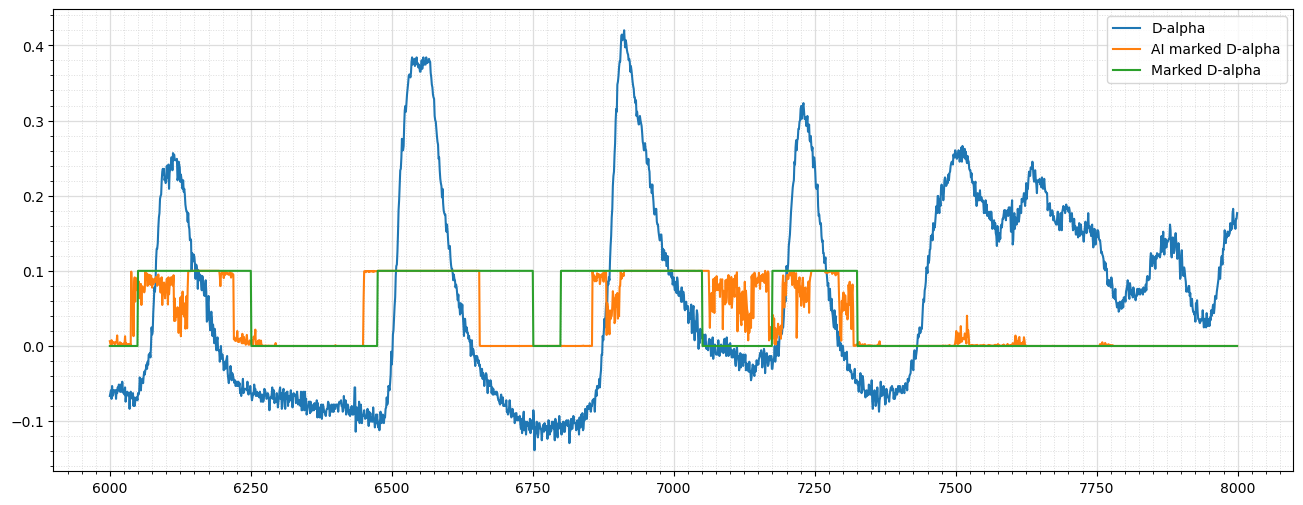

Input index pairs of ELM fragments:
 


<Figure size 640x480 with 0 Axes>

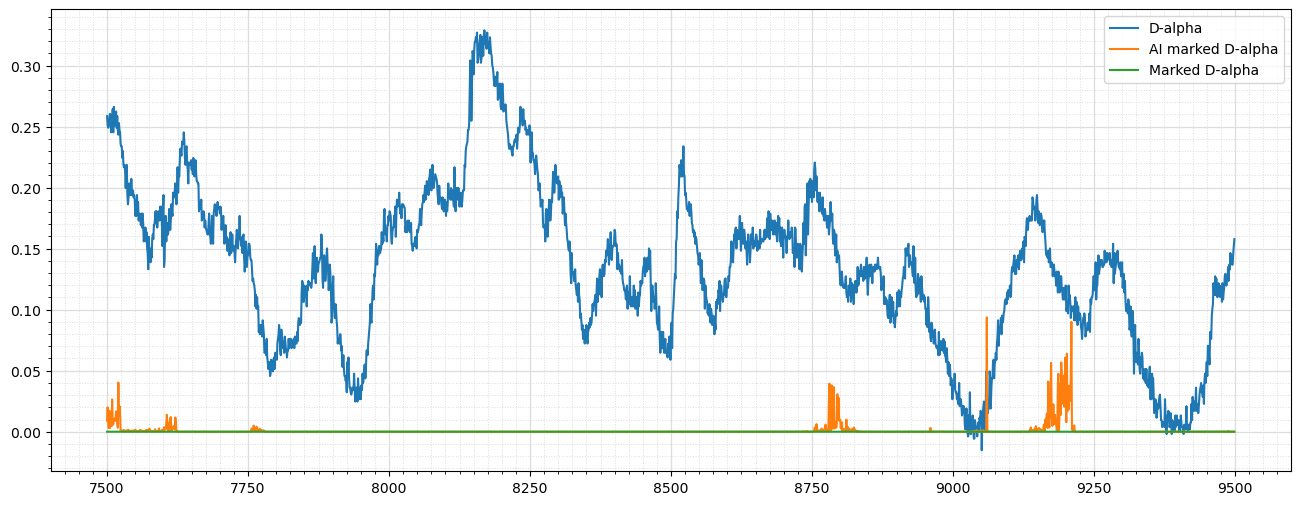

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator


l_edge = int(input(f"Input start index [0:{new_df.shape[0]}]: ").strip().split()[0])
step = 1500
width = 2000

while l_edge < new_df.shape[0]:
    fig, ax = plt.subplots()

    fig.set_figwidth(16)
    fig.set_figheight(6)

    r_edge = min(l_edge + width, new_df.shape[0])

    ax.plot(range(l_edge, r_edge), normalise_series(new_df.ch1)[l_edge:r_edge], label="D-alpha")  # new_df.iloc[l_edge:r_edge].t
    # ax.plot(range(l_edge, r_edge), new_df.ch1_filter_norm[l_edge:r_edge], label="Filtered D-alpha")
    ax.plot(range(l_edge, r_edge), new_df.ch1_ai_marked[l_edge:r_edge] / 10, label="AI marked D-alpha")
    ax.plot(range(l_edge, r_edge), new_df.ch1_marked[l_edge:r_edge] / 10, label="Marked D-alpha")

    ax.grid(which='major', color='#DDDDDD', linewidth=0.9)
    ax.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.7)
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax.legend()
    plt.show()

    res = list(map(int, input("Input index pairs of ELM fragments:\n").strip().split()))
    for i in range(0, len(res), 2):
        if (new_df.loc[res[i]:res[i + 1], "ch1_marked"] == 1).all():
            new_df.loc[res[i]:res[i + 1], "ch1_marked"] = 0
        elif (new_df.loc[res[i]:res[i + 1], "ch1_marked"] == 1).any():
            if input("Input y to set 1, n to set 0").lower() in ["y", "н"]:
                new_df.loc[res[i]:res[i + 1], "ch1_marked"] = 1
            else:
                new_df.loc[res[i]:res[i + 1], "ch1_marked"] = 0
        else:
            new_df.loc[res[i]:res[i + 1], "ch1_marked"] = 1

    plt.close()
    plt.clf()
    l_edge += step

In [57]:
new_df.to_csv(signal_path + f"df/{check_F_ID}_data.csv", index=False)

---
# AI prediction processing & evaluating
---

### Processing

In [58]:
def down_to_zero(data: np.array) -> np.array:
    edge = np.std(data)
    # print(edge)
    filter_values = np.vectorize(lambda x: 1.0 if abs(x) > edge else 0.0)
    return filter_values(data)

def clear_short_fragments(data: np.array) -> np.array:
    edge = 50

    start_ind = 0
    end_ind = 0
    
    while end_ind < data.shape[0]:
        if abs(data[end_ind] - 1.0) > 0.5:
            if start_ind != end_ind and end_ind - start_ind <= edge:
                data[start_ind: end_ind] = 0.0
            start_ind = end_ind
        end_ind += 1
    
    return data

In [36]:
new_df.describe()

,t,ch1,ch1_marked,ch1_ai_marked
count,393216.000000,393216.000000,393216.0,393216.000000
mean,0.196607,0.215997,0.0,0.072093
std,0.113512,0.323658,0.0,0.250502
min,0.000000,-0.398760,0.0,0.000000
25%,0.098304,0.012781,0.0,0.000000
50%,0.196607,0.063904,0.0,0.000000
75%,0.294911,0.385979,0.0,0.000000
max,0.393215,4.831128,0.0,1.000000


In [59]:
new_df['ch1_ai_marked'] = down_to_zero(new_df['ch1_ai_marked'].to_numpy())
new_df.describe()

,t,ch1,ch1_marked,ch1_ai_marked
count,393216.000000,393216.000000,393216.0,393216.000000
mean,0.196607,0.281714,0.0,0.066640
std,0.113512,0.393401,0.0,0.249398
min,0.000000,-0.388535,0.0,0.000000
25%,0.098304,0.012781,0.0,0.000000
50%,0.196607,0.066460,0.0,0.000000
75%,0.294911,0.575134,0.0,0.000000
max,0.393215,4.818347,0.0,1.000000


In [60]:
new_df['ch1_ai_marked'] = clear_short_fragments(new_df['ch1_ai_marked'].to_numpy())
new_df.describe()

,t,ch1,ch1_marked,ch1_ai_marked
count,393216.000000,393216.000000,393216.0,393216.000000
mean,0.196607,0.281714,0.0,0.053886
std,0.113512,0.393401,0.0,0.225794
min,0.000000,-0.388535,0.0,0.000000
25%,0.098304,0.012781,0.0,0.000000
50%,0.196607,0.066460,0.0,0.000000
75%,0.294911,0.575134,0.0,0.000000
max,0.393215,4.818347,0.0,1.000000


In [61]:
interval_df = pd.read_csv(interval_path + f"df/{check_F_ID}_data.csv")
interval_df.t *= 1e3
interval_df.head()

,t,ch1,ch1_marked,ch1_ai_marked
0,164470.0,0.51634,1,0.332097
1,164471.0,0.50612,1,0.964986
2,164472.0,0.50101,1,0.975182
3,164473.0,0.48823,1,0.969223
4,164474.0,0.48567,1,0.985926


In [62]:
new_df.loc[int(interval_df.t[0]): int(interval_df.t[interval_df.shape[0] - 1]), 'ch1_marked'] = interval_df.ch1_marked.to_numpy()
# print(new_df.loc[int(interval_df.t[0] * 1e6): int(interval_df.t[interval_df.shape[0] - 1] * 1e6), 'ch1_marked'], interval_df.ch1_marked)
new_df.describe()

,t,ch1,ch1_marked,ch1_ai_marked
count,393216.000000,393216.000000,393216.000000,393216.000000
mean,0.196607,0.281714,0.052422,0.053886
std,0.113512,0.393401,0.222876,0.225794
min,0.000000,-0.388535,0.000000,0.000000
25%,0.098304,0.012781,0.000000,0.000000
50%,0.196607,0.066460,0.000000,0.000000
75%,0.294911,0.575134,0.000000,0.000000
max,0.393215,4.818347,1.000000,1.000000


### Evaluating

In [65]:
print(sum(new_df.loc[:int(interval_df.t[0]), 'ch1_ai_marked']), sum(new_df.loc[int(interval_df.t[interval_df.shape[0] - 1]): , 'ch1_ai_marked']))

2129.0 2381.0


In [ ]:
class Slice:
    def __init__(self, name: str):
        self.start_ind = 0
        self.end_ind = 0
        self.name = name

    def check_edges(self, data: np.array):
        if abs(data[self.end_ind] - 1.0) > 0.5:
            if self.start_ind != self.end_ind and self.end_ind - self.start_ind <= edge:
                return -1  # new fragment
            return 0  # still nothing
        return 1  # still fragment

    def get_info(self, data_t: np.array, data_self: np.array, data_other: np.array):
        return [data_t[start_ind], data_t[end_ind], check_collision(data_other)]

    def check_collision(self, other_data: np.array):
        res_sum = sum(other_data[self.start_ind: self.end_ind])
        if res_sum >= (self.end_ind - self.start_ind) * 0.75:
            return 2  # strong collision
        elif res_sum > 50:
            return 1  # collision
        else:
            return 0  # no collision

    def step(self, data_self_len: int, mode=0):
        if self.end_ind + 1 < data_self_len:
            self.end_ind += 1
        else:
            return -1
        if mode == 1:
            self.start_ind = self.end_ind
        return 1

    def check_index(self, data_self_len: int):
        return self.end_ind < data_self_len

slices = [Slice(name="ch1_marked"), Slice(name="ch1_ai_marked")]
while any([x.check_index(new_df.shape[0]) for x in slices]):
    for sample in slices:
        

---
## Saving NN side
---

In [30]:
neu_version = 1
model.save(f"models/unet_v{neu_version}.keras")